In [1]:
import numpy as np
import pandas as pd
import timeit


In [2]:
train_orig =  pd.read_csv('train.csv', header=0)
test_orig =  pd.read_csv('test.csv', header=0)

tic0=timeit.default_timer()

df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_orig.copy()
test_cp = test_orig.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

In [3]:
train_comb[['id', 'q1_freq', 'q2_freq']].to_csv('train_comb.csv') 
test_comb[['id', 'q1_freq', 'q2_freq']].to_csv('test_comb.csv')

In [5]:
train_comb.to_csv('magicfeat_train.csv')

test_comb.to_csv('magicfeat_test.csv')


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

In [7]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780
()


/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


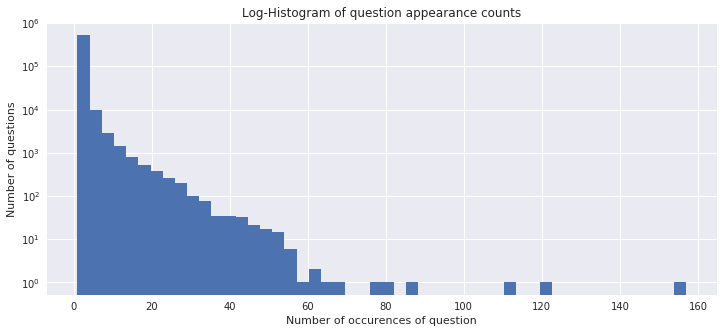

In [8]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [9]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

('Predicted score:', 0.65852738398443544)


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


In [10]:
df_test = pd.read_csv('test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [11]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


mean-train 59.86 std-train 31.99 mean-test 60.11 std-test 31.66 max-train 1169.00 max-test 1176.00


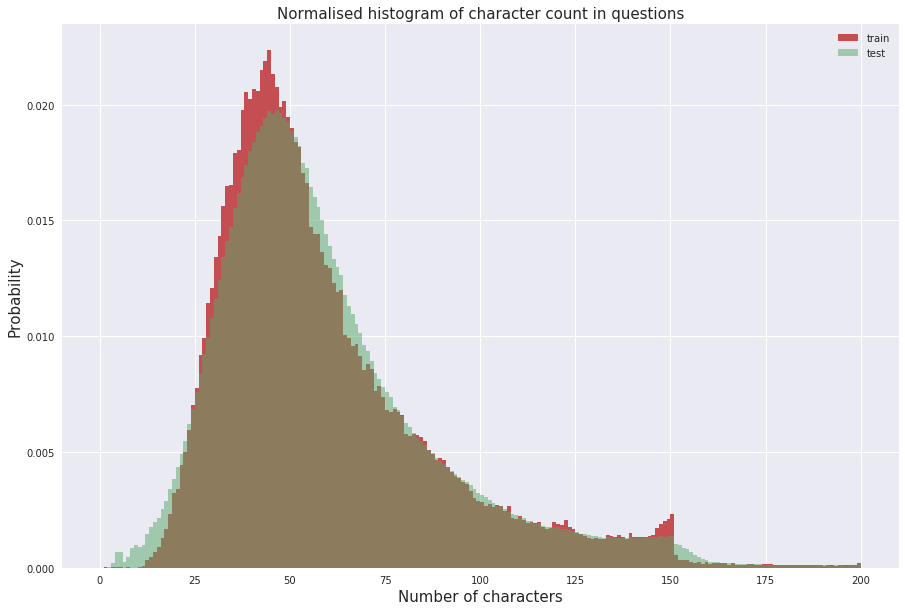

In [12]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


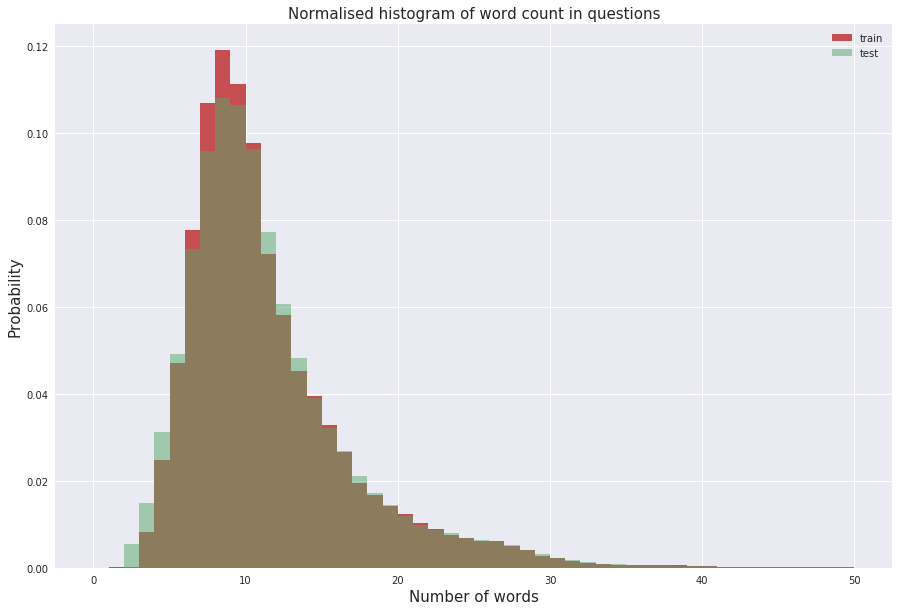

In [13]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

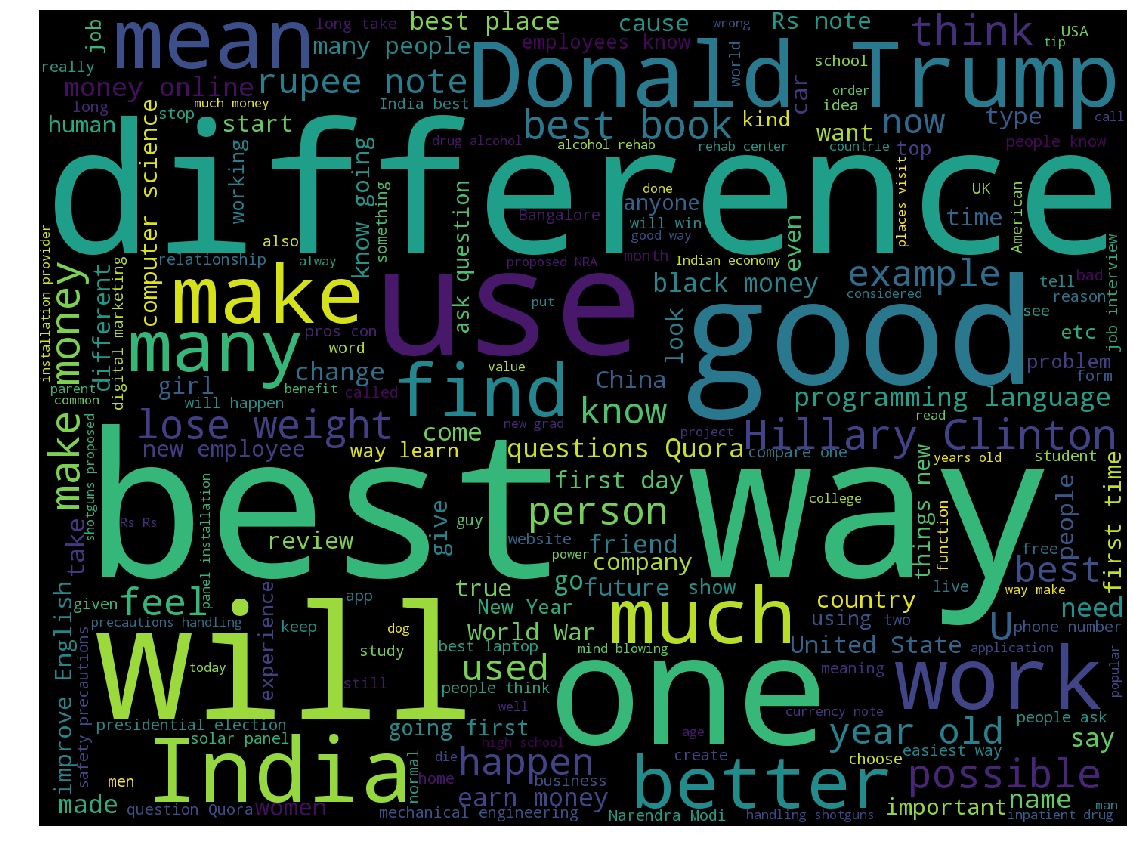

In [14]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [15]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


In [32]:
# df_train['is_duplicate'] = df_train.is_duplicate.astype(float)

train_word_match

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        1
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
404260    0
404261    0
404262    0
404263    0
404264    0
404265    0
404266    0
404267    0
404268    0
404269    0
404270    0
404271    0
404272    0
404273    0
404274    0
404275    0
404276    0
404277    0
404278    0
404279    0
404280    0
404281    0
404282    0
404283    0
404284    0
404285    0
404286    0
404287    0
404288    0
404289    1
dtype: int64

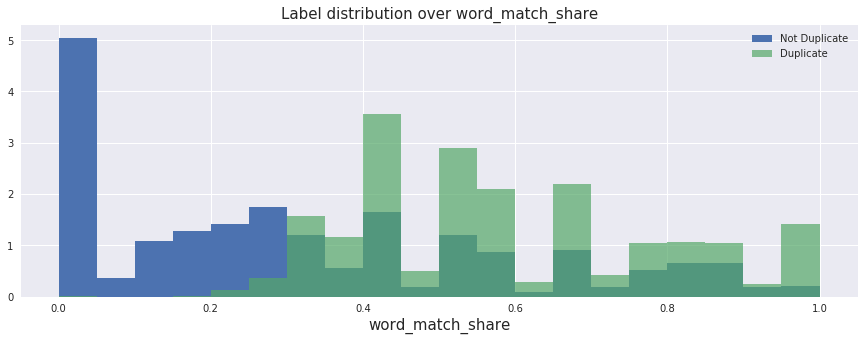

In [34]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float((len(shared_words_in_q1) + len(shared_words_in_q2)))/float((len(q1words) + len(q2words)))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=False)
plt.hist(train_word_match[df_train['is_duplicate'] == 0.0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1.0], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [39]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return float(1 / float((count + eps)))

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [40]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('chameleons', 9.998000399920016e-05),
 ('275', 9.998000399920016e-05),
 ('276', 9.998000399920016e-05),
 ('kid:', 9.998000399920016e-05),
 ('usenet', 9.998000399920016e-05),
 ('(football', 9.998000399920016e-05),
 ('dittofish?', 9.998000399920016e-05),
 ('sneha', 9.998000399920016e-05),
 ('population)', 9.998000399920016e-05),
 (',delhi', 9.998000399920016e-05)]

In [46]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = float(np.sum(shared_weights) / np.sum(total_weights))
    return R

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


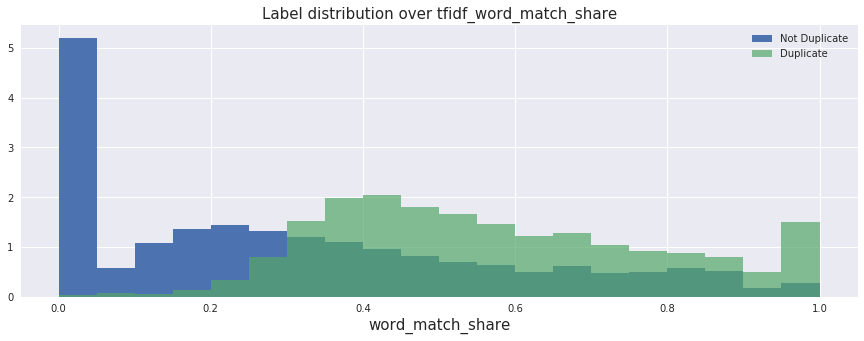

In [47]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0.0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1.0].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [64]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

('Original AUC:', 0.78055320062812139)
('   TFIDF AUC:', 0.77056665661851498)


In [71]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in long_scalars


In [73]:
x_train.to_csv('fanokas.csv')

x_test.to_csv('fanokas_test.csv')


In [70]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...

p = 0.165
scale = float(((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1)
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -= 1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print float((len(pos_train) / (len(pos_train) + len(neg_train))))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.0


In [ ]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

In [127]:
# x4 = pd.read_csv('owl_feat.csv')

# print x4.head()
col_to_drop = ['z_len1','z_len2','z_word_len1','z_word_len2','z_word_match']

x4.drop(col_to_drop, inplace = True, axis = 1)

x4.ix[:,9:]

,z_noun_match,z_match_ratio,z_tfidf_sum1,z_tfidf_sum2,z_tfidf_mean1,z_tfidf_mean2,z_tfidf_len1,z_tfidf_len2
0,4,0.926829,2.238763,2.086851,0.373127,0.417370,6,5
1,2,0.661871,2.200222,2.721306,0.440044,0.340163,5,8
2,1,0.439394,2.420729,2.203294,0.403455,0.440659,6,5
3,0,0.086957,1.722880,2.166837,0.574293,0.433367,3,5
4,2,0.365217,2.933787,1.985756,0.325976,0.496439,9,4
5,3,0.681818,2.552890,2.317292,0.319111,0.331042,8,7
6,0,0.222222,1.334850,2.485070,0.667425,0.355010,2,7
7,1,0.619718,1.272198,1.349630,0.636099,0.674815,2,2
8,0,0.852941,1.397585,1.397585,0.698793,0.698793,2,2
9,2,0.495413,2.322446,2.086167,0.387074,0.417233,6,5


In [75]:
x1 = pd.read_csv('quora_features.csv')
x2 = pd.read_csv('magicfeat_train.csv')
x3 = pd.read_csv('fanokas.csv')

print x1.head()
print x2.head()
print x3.head()

                                           question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  len_q1  \
0  What is the step by step guide to invest in sh...             0      66   
1  What would happen if the Indian government sto...             0      51   
2  How can Internet speed be increased by hacking...             0      73   
3  Find the remainder when [math]23^{24}[/math] i...             0      50   
4            Which fish would survive in salt water?             0      76   

   len_q2  diff_len  len_char_q1  len_char_q2  len_word_q1  len_word_q2  \
0      57         9           20           20           14           12   
1      88       -37           21           2

In [128]:
xf = pd.concat([x1,x2.ix[:,2:],x3.ix[:,1:],x4.ix[:,9:]], axis = 1)

xf.head()

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,word_match,tfidf_word_match,z_noun_match,z_match_ratio,z_tfidf_sum1,z_tfidf_sum2,z_tfidf_mean1,z_tfidf_mean2,z_tfidf_len1,z_tfidf_len2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,...,0.727273,0.772164,4,0.926829,2.238763,2.086851,0.373127,0.417370,6,5
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,...,0.307692,0.361758,2,0.661871,2.200222,2.721306,0.440044,0.340163,5,8
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,...,0.363636,0.355191,1,0.439394,2.420729,2.203294,0.403455,0.440659,6,5
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,9,...,0.000000,0.000000,0,0.086957,1.722880,2.166837,0.574293,0.433367,3,5
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,7,...,0.000000,0.000000,2,0.365217,2.933787,1.985756,0.325976,0.496439,9,4


In [149]:
x_train = xf.ix[:,3:]

y_train = x_train['is_duplicate'].values

x_train.drop('is_duplicate', inplace = True, axis = 1)


In [98]:
float(((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1)

NameError: name 'pos_train' is not defined

In [130]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = float(((float(len(pos_train)) / (float(len(pos_train)) + float(len(neg_train)))) / p) - 1)

print scale
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print float((float(len(pos_train)) / (float(len(pos_train)) + float(len(neg_train)))))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

1.23756274561
0.191243538485


In [150]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [117]:
x_valid

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,...,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,q1_hash,q2_hash,q1_freq,q2_freq,word_match,tfidf_word_match
376994,141,62,79,28,18,29,14,3,38,86,...,0.094980,0.103233,-0.132820,-0.130948,274090,521966,1,4,0.210526,0.221004
66972,67,99,-32,22,23,15,20,5,45,55,...,-0.015383,0.048489,-0.302879,-0.378358,60290,336366,3,1,0.222222,0.205623
319844,85,85,0,25,25,15,15,14,93,93,...,-0.182122,-0.058785,0.364106,0.072041,121760,147339,3,3,0.857143,0.837840
99034,22,120,-98,14,27,5,19,2,21,86,...,0.075718,-0.017378,-0.434383,0.214115,86223,357278,2,1,0.133333,0.097088
18809,44,40,4,17,19,7,7,1,51,53,...,-0.352661,-0.185735,-0.110410,0.049488,18151,14100,2,4,0.000000,0.000000
352525,38,44,-6,15,16,8,9,8,93,95,...,-0.079548,-0.079548,-0.121637,-0.121637,259277,112325,2,2,1.000000,1.000000
221080,68,132,-64,24,23,14,29,5,38,86,...,-0.063203,-0.089353,-0.160695,-0.208902,175091,432533,1,1,0.285714,0.192088
285925,78,94,-16,26,26,16,16,12,75,87,...,0.021833,-0.067892,-0.440617,0.181955,45892,2415,43,49,0.625000,0.570974
32456,79,166,-87,27,37,15,28,8,32,86,...,0.212307,0.279445,-0.516978,0.139242,30639,313208,1,1,0.230769,0.211388
220805,43,63,-20,19,18,7,11,4,62,71,...,-0.125182,-0.183643,-0.260287,-0.286368,174900,432360,1,1,0.600000,0.550740


In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 7
params['scale_pos_weight'] = 0.36

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=50, verbose_eval=100)

# [100]	train-logloss:0.31076	valid-logloss:0.311072
# [200]	train-logloss:0.272225	valid-logloss:0.272824
# [300]	train-logloss:0.263152	valid-logloss:0.264002
# [400]	train-logloss:0.256555	valid-logloss:0.257699

[0]	train-logloss:0.644886	valid-logloss:0.645426
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.34777	valid-logloss:0.363673
[200]	train-logloss:0.32392	valid-logloss:0.352158
[300]	train-logloss:0.306606	valid-logloss:0.346123
[400]	train-logloss:0.29345	valid-logloss:0.342767
[500]	train-logloss:0.28229	valid-logloss:0.34033
[600]	train-logloss:0.27058	valid-logloss:0.337838
[800]	train-logloss:0.252568	valid-logloss:0.334679
[900]	train-logloss:0.244819	valid-logloss:0.333514
[1000]	train-logloss:0.237213	valid-logloss:0.332208
[1100]	train-logloss:0.229644	valid-logloss:0.331142
[1200]	train-logloss:0.221499	valid-logloss:0.329959
[1300]	train-logloss:0.215053	valid-logloss:0.328934
[1400]	train-logloss:0.208951	valid-logloss:0.328286
[1500]	train-logloss:0.20285	valid-logloss:0.327605
[1600]	train-logloss:0.196124	valid-logloss:0.326779
[1700]	train-loglos

In [160]:
# 0.46*0.37/(1.32*(1- 0.37))

0.1746/0.3692

0.4729144095341279

In [ ]:
# params['objective'] = 'binary:logistic'
# params['eval_metric'] = 'logloss'
# params['eta'] = 0.02
# params['max_depth'] = 4
# [399]	train-logloss:0.264415	valid-logloss:0.265059
# [399]	train-logloss:0.256621	valid-logloss:0.257762  md  = 5 
# [999]	train-logloss:0.239906	valid-logloss:0.242298  md = 5
# [9999]	train-logloss:0.187486	valid-logloss:0.202274

mapping     = { }

df_train = pd.read_csv( settings["data_path"] + "/train.csv")
df_train["qmax"] = df_train.apply( lambda row: max( mapping.setdefault(row["question1"], len(mapping)), 
                                                   mapping.setdefault(row["question2"], len(mapping))), axis=1 )

df_test  = pd.read_csv( settings["data_path"] + "/test.csv")
df_test["qmax"] = df_test.apply( lambda row: max( mapping.setdefault(row["question1"], len(mapping)), 
                                                 mapping.setdefault(row["question2"], len(mapping))), axis=1 )


In [133]:
x1t = pd.read_csv('test_features.csv')
x2t = pd.read_csv('magicfeat_test.csv')
x3t = pd.read_csv('fanokas_test.csv')
x4t = pd.read_csv('owl_feat_test.csv')

col_to_drop = ['z_len1','z_len2','z_word_len1','z_word_len2','z_word_match']

x4t.drop(col_to_drop, inplace = True, axis = 1)

xft = pd.concat([x1t,x2t.ix[:,2:],x3t.ix[:,1:],x4t.ix[:,6:]], axis = 1)

x_test = xft.ix[:,2:]


In [142]:
df_test

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [ ]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb_ab_mg_an_2.csv', index=False)